In [1]:
# You can import *ANYTHING* you want here.
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error # Requires sklearn 0.24 (December 2020), update with conda/pip if needed.
from sklearn.model_selection import GridSearchCV, train_test_split

import pandas as pd

# Assignment 8: Tree methods

In this assignment we'll study tree methods and their capabilities as interpolators and extrapolators, and the importance of understanding your data. We will use a dataset of energy consumption of home appliances for houses in Chievres, Belgium. The data has the following variables:

- date time year-month-day hour:minute:second
- Appliances, energy use in Wh (**Target variable**)energy_extrapolation
- lights, energy use of light fixtures in the house in Wh
- T1, Temperature in kitchen area, in Celsius
- RH_1, Humidity in kitchen area, in %
- T2, Temperature in living room area, in Celsius
- RH_2, Humidity in living room area, in %
- T3, Temperature in laundry room area
- RH_3, Humidity in laundry room area, in %
- T4, Temperature in office room, in Celsius
- RH_4, Humidity in office room, in %
- T5, Temperature in bathroom, in Celsius
- RH_5, Humidity in bathroom, in %
- T6, Temperature outside the building (north side), in Celsius
- RH_6, Humidity outside the building (north side), in %
- T7, Temperature in ironing room , in Celsius
- RH_7, Humidity in ironing room, in %
- T8, Temperature in teenager room 2, in Celsius
- RH_8, Humidity in teenager room 2, in %
- T9, Temperature in parents room, in Celsius
- RH_9, Humidity in parents room, in %
- To, Temperature outside (from Chievres weather station), in Celsius
- Pressure (from Chievres weather station), in mm Hg
- RH_out, Humidity outside (from Chievres weather station), in %
- Wind speed (from Chievres weather station), in m/s
- Visibility (from Chievres weather station), in km
- Tdewpoint (from Chievres weather station), in C degrees

You are given two datasets: energy_appliances_standard.csv and energy_appliances_extrapolation.csv. The first dataset has typical consumption patterns, while the second one has the top 10% highest consumptions and will be used to test the extrapolating capacities of our models.


## Task 1: Random Forests (35/100)

Random Forests are excellent predictors. Usually we only need to tune one parameter: the number of trees in the model. However, how many trees are enough? Follow these steps:

1. Load the training dataset (energy_appliances_standard.csv) and show the descriptive statistics of the variables. (3 pts)

2. Create a train / test partition of the data using 30% of the data for the test set and a ```random_state``` value of 20201107(2 pts).

3. Follow [this example](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html) and train a [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) using ```Appliances``` as the target variable. Test between 50 and 250 trees, plotting the Out-of-Bag (OOB) error after every iteration. Be patient as training can take a while. Written answer: What is the optimal number of trees for your model and why do you think this? (15 pts)

4. Train your final random forest with the number of trees you selected in part 3. Apply this model over your test set and over the extrapolating dataset (from the file ```energy_appliances_extrapolation.csv```), calculating the mean absolute percentual error for each dataset.  Show in a scatterplot the predicted value vs the real value of the target variable for both the test set and the extrapolation set (in the same plot), differentiating both by using different colors for the points. Written answer: How does the random forest model perform on predicting Appliance energy usage in the extrapolation data set? If it performs poorly, why? If it performs well, why? *Hint: look at the scatterplot*. (15 points)

In [2]:
# Data load
data = pd.read_csv('energy_appliances_standard.csv')
data.describe()


,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
count,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,...,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000,17735.000000
mean,68.121229,3.445729,21.688855,40.150264,20.293891,40.469997,22.230926,39.160423,20.860319,38.983631,...,22.050534,43.016242,19.505556,41.552215,7.314032,755.566425,80.249079,3.969812,38.305214,3.762879
std,30.182146,7.552424,1.604312,3.930099,2.171999,4.063088,1.969945,3.219280,2.047586,4.320711,...,1.961083,5.202160,2.010550,4.161873,5.291010,7.339842,14.768037,2.447164,11.957900,4.187098
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,...,16.306667,29.600000,14.890000,29.166667,-5.000000,729.366667,24.000000,0.000000,1.000000,-6.600000
25%,50.000000,0.000000,20.760000,37.260000,18.790000,37.930000,20.790000,36.826667,19.566667,35.500000,...,20.828889,39.200000,18.066667,38.530000,3.500000,751.000000,71.333333,2.000000,29.000000,0.933333
50%,60.000000,0.000000,21.600000,39.533333,19.926667,40.545000,22.100000,38.466667,20.666667,38.363333,...,22.166667,42.440000,19.390000,40.863333,6.850000,756.100000,84.333333,3.500000,40.000000,3.433333
75%,80.000000,0.000000,22.600000,42.863333,21.463333,43.326667,23.290000,41.530000,22.100000,42.066667,...,23.390000,46.590000,20.600000,44.290000,10.333333,760.950000,91.845238,5.333333,40.000000,6.550000
max,190.000000,50.000000,26.200000,59.633333,29.856667,56.026667,29.100000,49.656667,26.200000,51.000000,...,27.230000,58.780000,24.500000,53.326667,26.100000,772.283333,100.000000,14.000000,66.000000,15.500000


In [3]:
# Create train / test split
train_data, test_data = train_test_split(data, test_size = 0.3, random_state = 20201107) 

In [4]:
# Train random forest regressor
X = train_data.iloc[:, 1:]
y = train_data['Appliances']

min_trees = 50
max_trees = 250
error_rate = list()

for i in range(min_trees, max_trees + 1):
    reg = RandomForestRegressor(n_estimators=i, 
                            max_depth=None, 
                            min_samples_split=2, 
                            min_samples_leaf=0.001, 
                            min_weight_fraction_leaf=0.0, 
                            max_features='auto', 
                            max_leaf_nodes=None, 
                            min_impurity_decrease=0.0001, 
                            bootstrap=True, 
                            oob_score=True, 
                            n_jobs=-1, 
                            random_state=20190305, 
                            verbose=1, 
                            warm_start=False)
    reg.fit(X, y)

    # Record oob error
    oob_error = 1 - reg.oob_score_
    error_rate.append((i, oob_error))


ished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 173 out of 173 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 174 out of 174 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 176 out of 176 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed

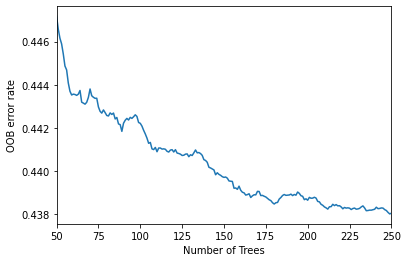

In [5]:
# Plot the OOB error per number of trees
xs, ys = zip(*error_rate)
plt.plot(xs, ys)

plt.xlim(min_trees, max_trees)
plt.xlabel("Number of Trees")
plt.ylabel("OOB error rate")
plt.show()

**Written answer:** The optimal number of trees is about 210 because the Out-Of-Bag error appears to stabilize around this number.

In [6]:
# Final forest
reg = RandomForestRegressor(n_estimators=210, 
                            max_depth=None, 
                            min_samples_split=2, 
                            min_samples_leaf=0.001, 
                            min_weight_fraction_leaf=0.0, 
                            max_features='auto', 
                            max_leaf_nodes=None, 
                            min_impurity_decrease=0.0001, 
                            bootstrap=True, 
                            oob_score=True, 
                            n_jobs=-1, 
                            random_state=20190305, 
                            verbose=1, 
                            warm_start=False)

reg.fit(X, y)

# Calculate error over test set
X_test = test_data.iloc[:, 1:]
y_test = test_data['Appliances']

ypred = reg.predict(X_test)
mape = mean_absolute_percentage_error(y_test, ypred)

# Load the second dataset
extrapolation_data = pd.read_csv('energy_appliances_extrapolation.csv')
X_ep = extrapolation_data.iloc[:, 1:]
y_ep = extrapolation_data['Appliances']

# Calculate the error over it
ypred_ep = reg.predict(X_ep)
mape_ep = mean_absolute_percentage_error(y_ep, ypred_ep)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    7.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 210 out of 210 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 210 out of 210 | elapsed:    0.1s finished


In [7]:
# Print MAPE over the sets
print('Test set MAPE: ', mape)
print('Extrapolation set MAPE: ', mape_ep)

Test set MAPE:  0.22158164227451796
Extrapolation set MAPE:  0.724981483297344


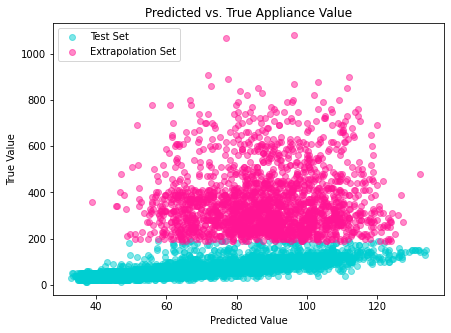

In [8]:
# Make the scatterplot
plt.figure(figsize=(7,5))
plt.scatter(ypred, y_test, color='darkturquoise', alpha=0.5, label='Test Set')
plt.scatter(ypred_ep, y_ep, color='deeppink', alpha=0.5, label='Extrapolation Set')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.title('Predicted vs. True Appliance Value')
plt.legend(loc='upper left')
plt.show()

**Written answer: ** The random forest model performs poorly with the extrapolated data. This is due to how Random Forests/Decision Trees work. They directly use the given training data in order to create a model that predicts outcomes. Therefore, if a sample falls outside of the range of the already seen data, it will assume that the prediction will be close to either the maximum or minimum value in the training set. As we can see from the scatterplot, all of the extrapolated data predictions fall within the range of the predictions from the already seen values.

## Task 2: XGBoosting model (40 pts)

Now we'll repeat the process for the XGB model, using an [```XGBRegressor``` object](https://xgboost.readthedocs.io/en/latest/python/python_api.html). The XGBoosting model is much more sensitive to parameter changes though as it allows to tune many different parameters. For this example:

1. Written answer: Why do we say we want to use a small learning rate? Why do we say the number of trees to use depends on each dataset/problem? Why do we want to use a small tree depth? (6 pts)

2. Selecting a 30% validation sample over the training set, tune your parameters using crossvalidation. Use the following ranges:
 - Learning rate: [0.01, 0.1, 0.2].
 - max_depth: 3 to 7.
 - Number of trees: [350, 400, 450, 500]

Leave the other parameters at the values we identified in the lab (except for the objective parameter and those related to classification problems) and use a seed of 20201107. Report the optimal values of your parameters. (20 pts)

3. Repeat part 4 of the previous task, but now for your XGB model trained over the optimal parameter combination and the complete training dataset. Plot the variable importance. Written answer: What are the most important variables? Can the XGB model extrapolate? How does it compare to a random forest? (14 pts)

**Written answer part 1 (2 pts each):** 

We want to use a small learning rate because a learning rate that is too large might surpass (step over) the minimum. It's good to test several rates because a learning rate too small may use too many steps. 

The number of trees depends on each dataset because every dataset is different; there may be more variables, more samples, etc. This will vary the results of a model. Using more trees improves the results of a model, however the error will eventually stabilize and therefore, using too many trees will be unnecessarily computationally expensive. Each dataset error may stabilize at a different point depending on various factors. 

We want to use a small tree depth because boosting fits an additive model meaning that each tree learns from the previous one. This means that we can use a small tree depth since, although they are weak learners, combining them creates accurate and flexible models. Using a larger depth can lead to overfitting.


In [9]:
# Define the XGB model
XGB = XGBRegressor(max_depth=3,                 
                    learning_rate=0.1,           
                    n_estimators=100,           
                    verbosity=1,                  
                    booster='gbtree',             
                    n_jobs=2,                  
                    gamma=0.001,                 
                    subsample=1,                 
                    colsample_bytree=1,          
                    colsample_bylevel=1,        
                    colsample_bynode=1,           
                    reg_alpha=1,                  
                    reg_lambda=0,                
                    scale_pos_weight=1,           
                    base_score=0.5,              
                    random_state=20201107,        
                    missing=None                 
                    )


In [10]:
# Define the parameter grid.
param_grid = dict({'n_estimators': [350, 400, 450, 500],
                    'max_depth': [3, 4, 5, 6, 7],
                    'learning_rate': [0.01, 0.1, 0.2]
                    })

In [11]:
# Create reduced validation set.
val_train = train_data.sample(frac = 0.3, random_state = 20201107)

In [12]:
# Train grid search. This takes a while! Go grab a coffee.
GridXGB = GridSearchCV(XGB,       
                       param_grid,          
                       cv = 3,             
                       scoring = 'neg_mean_absolute_percentage_error', 
                       n_jobs = -1,       
                       refit = False,     
                       verbose = 1       
                      )

GridXGB.fit(val_train.iloc[:, 1:], val_train['Appliances'])

Fitting 3 folds for each of 60 candidates, totalling 180 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0.001,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=3, min_child_weight=None,
                                    missing=None, monotone_constraints=None,
                                    n_estimators=100, n_jobs=2,
                                    num_parallel_tree=None,
                                    random_state=20201107, reg_alpha=1,
                                    reg_lambda=0, scale_pos_weight=1,
                                    subsample=1, tree_method=None,
                                    validate_parameters=None, verbos

In [13]:
# Show best params
GridXGB.best_params_

{'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 350}

In [14]:
# Train final XGB with optimal parameters
XGB = XGBRegressor(max_depth=GridXGB.best_params_.get('max_depth'),                 
                    learning_rate=GridXGB.best_params_.get('learning_rate'),           
                    n_estimators=GridXGB.best_params_.get('n_estimators'),           
                    verbosity=1,                  
                    booster='gbtree',             
                    n_jobs=2,                  
                    gamma=0.001,                 
                    subsample=1,                 
                    colsample_bytree=1,          
                    colsample_bylevel=1,        
                    colsample_bynode=1,           
                    reg_alpha=1,                  
                    reg_lambda=0,                
                    scale_pos_weight=1,           
                    base_score=0.5,              
                    random_state=20201107,        
                    missing=None                 
                    )

XGB.fit(train_data.iloc[:, 1:], train_data['Appliances'])


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.001, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=None, monotone_constraints='()',
             n_estimators=350, n_jobs=2, num_parallel_tree=1,
             random_state=20201107, reg_alpha=1, reg_lambda=0,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=1)

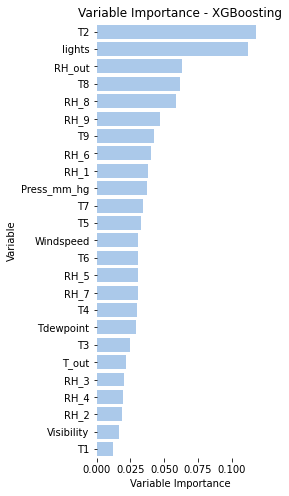

In [15]:
# Variable importance
importances = XGB.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3, 8))
plt.title("Variable Importance - XGBoosting")
sns.set_color_codes("pastel")
sns.barplot(y=[train_data.iloc[:, 1:].columns[i] for i in indices], x=importances[indices], 
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance")
sns.despine(left=True, bottom=True)

**Written answer:** The most important variables are T2 and lights.

Test set MAPE:  0.22395751690811275
Extrapolation set MAPE:  0.7298119230496434


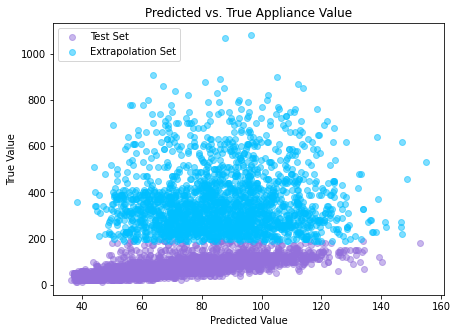

In [16]:
# Make scatterplot
ypred = XGB.predict(X_test)
mape = mean_absolute_percentage_error(y_test, ypred)

ypred_ep = XGB.predict(X_ep)
mape_ep = mean_absolute_percentage_error(y_ep, ypred_ep)

print('Test set MAPE: ', mape)
print('Extrapolation set MAPE: ', mape_ep)

plt.figure(figsize=(7,5))
plt.scatter(ypred, y_test, color='mediumpurple', alpha=0.5, label='Test Set')
plt.scatter(ypred_ep, y_ep, color='deepskyblue', alpha=0.5, label='Extrapolation Set')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.title('Predicted vs. True Appliance Value')
plt.legend(loc='upper left')
plt.show()


**Written answer: ** The XGB model is slightly worse than the random forest model. This model still cannot extrapolate, due to the same reason as stated for the random forest model. All tree-based models are bad at extrapolation. 

## Task 3: Combined model (25 pts)

Now we will finally train a model on the combined data, by joining the extrapolation and the original dataset, and study the performance over the original test set, the new test set and the combined result. For this we will only use the Random Forest model. Use a seed of 20201107 for all functions that accept one.

1. Create a train / test split set over the extrapolation data, leaving approximately 30% of the data for testing purposes. Combine this train test with the original train set (let's call this the combined train set). (5 pts)
2. Train a Random Forest model over the **combined** train data. Discuss how many trees you used and why. (15 pts)
3. Plot the variable importance and compare it versus the XGB in task 1. Now that you more data, does the importance change? (5 pts)
3. Report the test set performance of your new model over the original test set, the test set you took over the extrapolation dataset and the combined test set. Plot the scatterplot of the both datasets as before in the same plot, differentiating the dataset by using colours. (10 pts)

Written answer: What happens now? What can you say about the new model?

In [22]:
# Create the new train and test set.
train_data_ep, test_data_ep = train_test_split(extrapolation_data, test_size = 0.3, random_state = 20201107) 

combined_train = pd.concat([train_data_ep, train_data], axis=0)
combined_test = pd.concat([test_data_ep, test_data], axis=0)

In [23]:
# Obtain the new random forest (tune the trees)
reg_combined = RandomForestRegressor(n_estimators=210, 
                            max_depth=None, 
                            min_samples_split=2, 
                            min_samples_leaf=0.001, 
                            min_weight_fraction_leaf=0.0, 
                            max_features='auto', 
                            max_leaf_nodes=None, 
                            min_impurity_decrease=0.0001, 
                            bootstrap=True, 
                            oob_score=True, 
                            n_jobs=-1, 
                            random_state=20190305, 
                            verbose=1, 
                            warm_start=False)

reg_combined.fit(combined_train.iloc[:, 1:], combined_train['Appliances'])


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:    4.9s finished


RandomForestRegressor(min_impurity_decrease=0.0001, min_samples_leaf=0.001,
                      n_estimators=210, n_jobs=-1, oob_score=True,
                      random_state=20190305, verbose=1)

I decided to use 210 trees because, as seen earlier, this is what worked best for the previous Random Forest model. 

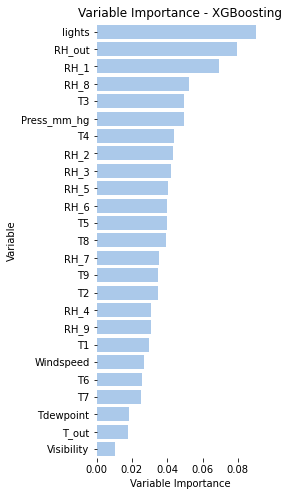

In [24]:
# Variable importance
importances = reg_combined.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3, 8))
plt.title("Variable Importance - XGBoosting")
sns.set_color_codes("pastel")
sns.barplot(y=[combined_train.iloc[:, 1:].columns[i] for i in indices], x=importances[indices], 
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance")
sns.despine(left=True, bottom=True)

**Written answer: ** The importance did change. lights became the most important variable, which didn't change much. The two next most important variables are RH_out and RH_1. Interestingly, T2 went down in importance a lot compared to the previous model trained with less data.

In [25]:
# Print MAPE over the test sets
ypred = reg_combined.predict(X_test)
mape = mean_absolute_percentage_error(y_test, ypred)

X_ep = test_data_ep.iloc[:, 1:]
y_ep = test_data_ep['Appliances']

ypred_ep = reg_combined.predict(X_ep)
mape_ep = mean_absolute_percentage_error(y_ep, ypred_ep)

X_combined = combined_test.iloc[:, 1:]
y_combined = combined_test['Appliances']

ypred_combined = reg_combined.predict(X_combined)
mape_combined = mean_absolute_percentage_error(y_combined, ypred_combined)

print('Test set MAPE: ', mape)
print('Extrapolation set MAPE: ', mape_ep)
print('Combined set MAPE: ', mape_combined)

print(X_test.size)
print(X_combined.size)
print(X_ep.size)


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 210 out of 210 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 210 out of 210 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
Test set MAPE:  0.4131166230063803
Extrapolation set MAPE:  0.436862321074258
Combined set MAPE:  0.41552287513283315
133025
148025
15000
[Parallel(n_jobs=12)]: Done 210 out of 210 | elapsed:    0.1s finished


Test set MAPE:  0.4131166230063803
Extrapolation set MAPE:  0.436862321074258
Combined set MAPE:  0.41552287513283315


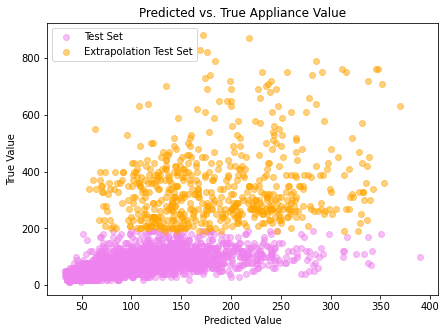

In [26]:
# Scatterplot

# Reprinting for visibility 
print('Test set MAPE: ', mape)
print('Extrapolation set MAPE: ', mape_ep)
print('Combined set MAPE: ', mape_combined)

plt.figure(figsize=(7,5))
plt.scatter(ypred, y_test, color='violet', alpha=0.5, label='Test Set')
plt.scatter(ypred_ep, y_ep, color='orange', alpha=0.5, label='Extrapolation Test Set')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.title('Predicted vs. True Appliance Value')
plt.legend(loc='upper left')
plt.show()

**Written answer:** The test set MAPE increased and the extrapolation MAPE decreased. The increase of the test set MAPE is probably due to the fact that the extrapolation samples are removing focus from the interpolation samples, making it more difficult to zone in on correct predictions. The extrapolation MAPE increased because those samples were now included in the training data. Overall, the MAPE increased. I would predict that this is because there is more variance in the data now, making it more difficult for the trees to identify an accurate trend.